In [1]:
import numpy as np
import gymnasium as gym
from collections import defaultdict  # required for creating Q(s, a)
from moviepy import ImageSequenceClip # to generate gif
from IPython.display import Image

import matplotlib 
#matplotlib.use('Qt5Agg') # Activte it if you want external plot for any interaction
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# We train our agent by SARSA in two following environments

envs = ['Taxi-v3', 'CliffWalking-v1']

In [3]:
# This functions are for visualization of episodes after training
# -------------------------
# Render Episodes Using RGB Frames
# -------------------------



def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)

    
    
def run_multi_episodes(env, Q_table, run_num=10, epsilon=0):
    """Run a single episode using the learned Q-table."""
    total_frames = []
    total_reward = []
    for run in range(run_num):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        frames = [env.render()]

        while not done:
            action = np.argmax(Q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            frames.append(env.render())
            episode_reward += reward
            state = next_state
        total_frames.extend(frames)
        total_reward.append(episode_reward)
    return total_frames, total_reward

### Q-learning update function 

| Concept                        | **Q-learning**                                          | **SARSA**                                                     |
| ------------------------------ | ------------------------------------------------------- | ------------------------------------------------------------- |
| **Type**                       | Off-policy                                              | On-policy                                                     |
| **Next action used in update** | `maxₐ′ Q(s′, a′)` (best possible next action)           | `Q(s′, a′)` (action actually taken by current policy)         |
| **Behavior**                   | Learns the *optimal policy* regardless of exploration   | Learns the *current policy’s* behavior (includes exploration) |
| **Effect**                     | Faster convergence, but can be riskier                  | Safer, more conservative learning                             |
| **Update rule**                | `Q(s,a) ← Q(s,a) + α [r + γ * maxₐ′ Q(s′,a′) − Q(s,a)]` | `Q(s,a) ← Q(s,a) + α [r + γ * Q(s′,a′) − Q(s,a)]`             |


In [4]:
def q_learning_update(Q_table, state, action, reward, next_state, alpha, gamma):
    """
    Perform Q-learning update on the Q-table.

    Parameters:
    ----------
    Q_table : numpy.ndarray
        The table of Q-values with shape [num_states, num_actions].
        Each entry Q[s, a] represents the agent's current estimate 
        of the expected future reward for taking action 'a' in state 's'.

    state : int
        The current state (s_t).
    
    action : int
        The action taken from the current state (a_t).
    
    reward : float
        The immediate reward received after taking the action.
    
    next_state : int
        The state reached after taking the action (s_{t+1}).
    
    alpha : float
        Learning rate (0 < α ≤ 1). Determines how much new information overrides old estimates.
    
    gamma : float
        Discount factor (0 ≤ γ < 1). Represents how much future rewards are valued.

    --------------------
    Core Idea:
    --------------------
    Q-learning is an **off-policy Temporal Difference (TD)** control algorithm.
    It updates the Q-value toward the **maximum possible future return**,
    assuming the agent will act optimally from the next state onward.

    The update rule is:
        Q(s, a) ← Q(s, a) + α [ r + γ * maxₐ′ Q(s′, a′) − Q(s, a) ]

    This differs from SARSA, which uses Q(s′, a′) from the *actual* next action 
    (on-policy). Q-learning instead assumes the *best* action (off-policy).
    """

    # 1️⃣ Compute the target (expected optimal return)
    #    Instead of following the action actually taken, 
    #    we assume the *optimal* next action will be chosen.
    target = reward + gamma * np.max(Q_table[next_state, :])

    # 2️⃣ Compute the TD error
    #    The difference between the target return and current estimate.
    td_error = target - Q_table[state, action]

    # 3️⃣ Update Q-value for the current (state, action) pair
    #    Move the current Q-value toward the target by a fraction α.
    Q_table[state, action] += alpha * td_error


In [5]:
def epsilon_greedy(env, Q_table, state, epsilon):
    """
    Select an action using the epsilon-greedy policy.

    Parameters:
    env : gym.Env
        The environment, used here to sample a random action when exploring.
    Q_table : numpy.ndarray
        The Q-value table with shape [num_states, num_actions].
    state : int
        The current state.
    epsilon : float
        The exploration rate (0 ≤ epsilon ≤ 1). 
        With probability epsilon, choose a random action (exploration);
        otherwise, choose the best-known action (exploitation).

    Returns:
    action : int
        The action chosen according to the epsilon-greedy rule.
    """

    # 1️⃣ Generate a random number in [0, 1)
    #    This random draw decides whether the agent explores or exploits.
    if np.random.random() < epsilon:
        # 2️⃣ EXPLORATION:
        #     With probability ε, select a random action from the environment's action space.
        #     This encourages discovering new or less-visited actions.
        return env.action_space.sample()
    else:
        # 3️⃣ EXPLOITATION:
        #     With probability (1 - ε), select the action with the highest Q-value
        #     for the current state — the best known action according to current knowledge.
        return np.argmax(Q_table[state])


In [6]:
def Train_Q_Learning(envIdx, episodes_num, printout, output_name, alpha=0.1, gamma=0.99, epsilon=0.1):
    """
    Train an agent using the Q-learning algorithm on the specified environment.

    Parameters:
    ----------
    envIdx : int
        Index of the environment from the list `envs`.
    episodes_num : int
        Number of episodes to train the agent.
    printout : int
        Frequency (in episodes) of printing training progress.
    output_name : str
        Identifier for saving metrics and visualizations.
    alpha : float, default=0.1
        Learning rate (0 < α ≤ 1). Controls how much new information overrides old Q-values.
    gamma : float, default=0.99
        Discount factor (0 ≤ γ < 1). Determines importance of future rewards.
    epsilon : float, default=0.1
        Exploration rate for ε-greedy policy. Controls trade-off between exploration and exploitation.

    --------------------
    Core Idea:
    --------------------
    Q-learning is an **off-policy Temporal-Difference (TD)** algorithm.
    Unlike SARSA (which is on-policy), Q-learning assumes that the agent
    always takes the *best possible next action* when computing its updates.

    The update rule:
        Q(s, a) ← Q(s, a) + α [r + γ * maxₐ′ Q(s′, a′) − Q(s, a)]
    """

    # 1️⃣ Initialize the environment
    env = gym.make(envs[envIdx])

    # 2️⃣ Initialize the Q-table
    # Each cell Q[s, a] represents the expected return for taking action 'a' in state 's'
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q_table = np.zeros((n_states, n_actions))
    print(f'Environment {envs[envIdx]}:\n    Size of observation space: {n_states}\n    Size of action space: {n_actions}')

    # 3️⃣ Track episode rewards and lengths for analysis
    episode_rewards = []
    episode_lengths = []

    # 4️⃣ Main training loop
    for episode in range(episodes_num):
        # Reset environment and get the initial state
        state, _ = env.reset()

        # Choose initial action using ε-greedy policy
        action = epsilon_greedy(env, Q_table, state, epsilon)

        done = False
        total_reward = 0
        steps = 0

        # 5️⃣ Interact with the environment until the episode ends
        while not done:
            # Take the chosen action and observe the outcome
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Choose the next action (for ε-greedy behavior policy)
            # Note: This action is used for exploration, NOT for the Q-learning update.
            next_action = epsilon_greedy(env, Q_table, next_state, epsilon)

            # 6️⃣ Q-learning update
            # Unlike SARSA, the update does NOT use the actual 'next_action' taken.
            # It assumes the agent takes the best (greedy) action in the next state.
            q_learning_update(Q_table, state, action, reward, next_state, alpha, gamma)

            # Move to the next step
            state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        # 7️⃣ Store episode statistics
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # 8️⃣ Decay ε to reduce exploration over time
        epsilon *= 0.99

        # 9️⃣ Periodically display training progress
        if episode % printout == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")

    # 🔟 Plot learning performance across episodes
    plt.figure(figsize=(12, 5))

    # Plot total reward per episode
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Episode Return (Q-learning)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    # Plot episode lengths (number of steps per episode)
    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Number of Steps")

    plt.tight_layout()
    plt.savefig(f'learning_progress_{envs[envIdx]}_{output_name}.png', bbox_inches='tight', dpi=100)
    plt.close()

    # 🔁 Test and visualize the trained policy
    env_vis = gym.make(envs[envIdx], render_mode='rgb_array')
    frames, total_reward = run_multi_episodes(env_vis, Q_table, run_num=5)
    create_gif(frames, f"trained_{envs[envIdx]}_{output_name}.gif", fps=5)
    print(f"Episodes completed with total rewards: {total_reward}")

    env.close()


### Training agent with Q-learning in Taxi-v3

In [7]:
# training the agent and visualizing some episodes for Taxi-v3 env

Train_Q_Learning(0, 20000, 2500, '1', alpha=0.1, gamma=0.99, epsilon=0.1)

Environment Taxi-v3:
    Size of observation space: 500
    Size of action space: 6
Episode 0, Avg Reward: -740.00, Avg Length: 200.00
Episode 2500, Avg Reward: 7.70, Avg Length: 13.30
Episode 5000, Avg Reward: 7.80, Avg Length: 13.20
Episode 7500, Avg Reward: 8.32, Avg Length: 12.68
Episode 10000, Avg Reward: 8.38, Avg Length: 12.62
Episode 12500, Avg Reward: 7.85, Avg Length: 13.15
Episode 15000, Avg Reward: 8.15, Avg Length: 12.85
Episode 17500, Avg Reward: 7.93, Avg Length: 13.07
MoviePy - Building file trained_Taxi-v3_1.gif with imageio.


Episodes completed with total rewards: [11, 5, 9, 10, 11]


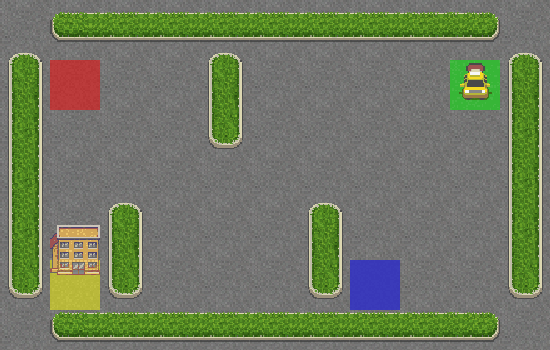

In [8]:
Image('./trained_Taxi-v3_1.gif')

<br><br>

### Training agent with Q-learning in CliffWalking-v1

Previously, we trained the CliffWalking environment using **SARSA** with different exploration rates, ε = 0.1 and ε = 0.9. With **ε = 0.1**, the agent tends to stick close to the cliff edge, taking the shorter but riskier path. With **ε = 0.9**, the agent explores more and tends to avoid the cliff, choosing safer routes.

In contrast, with **Q-learning**, the agent always updates toward the *optimal path* regardless of ε. This means that no matter how much it explores, it tends to take the path closest to the cliff edge—the shortest, “optimal” route.



In [9]:
# training the agent and visualizing some episodes for CliffWalking-v1 env
# limit the exploration by 0.1
Train_Q_Learning(1, 500, 50, 'eps_01', alpha=0.1, gamma=0.99, epsilon=0.1)

Environment CliffWalking-v1:
    Size of observation space: 48
    Size of action space: 4
Episode 0, Avg Reward: -87.00, Avg Length: 87.00
Episode 50, Avg Reward: -225.39, Avg Length: 120.57
Episode 100, Avg Reward: -141.70, Avg Length: 82.30
Episode 150, Avg Reward: -45.91, Avg Length: 37.00
Episode 200, Avg Reward: -31.25, Avg Length: 27.29
Episode 250, Avg Reward: -24.62, Avg Length: 21.65
Episode 300, Avg Reward: -20.82, Avg Length: 17.85
Episode 350, Avg Reward: -15.88, Avg Length: 14.89
Episode 400, Avg Reward: -13.24, Avg Length: 13.24
Episode 450, Avg Reward: -14.11, Avg Length: 13.12
MoviePy - Building file trained_CliffWalking-v1_eps_01.gif with imageio.


Episodes completed with total rewards: [-13, -13, -13, -13, -13]


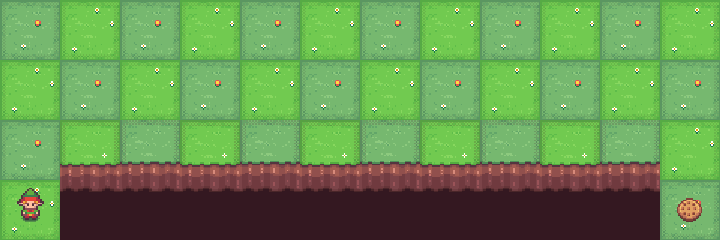

In [10]:
Image('./trained_CliffWalking-v1_eps_01.gif')

In [11]:
# training the agent and visualizing some episodes for CliffWalking-v1 env
# allow the exploration by 0.9
Train_Q_Learning(1, 500, 50, 'eps_09', alpha=0.1, gamma=0.99, epsilon=0.9)

Environment CliffWalking-v1:
    Size of observation space: 48
    Size of action space: 4
Episode 0, Avg Reward: -44792.00, Avg Length: 4994.00
Episode 50, Avg Reward: -3838.16, Avg Length: 446.92
Episode 100, Avg Reward: -1604.63, Avg Length: 198.83
Episode 150, Avg Reward: -150.28, Avg Length: 35.44
Episode 200, Avg Reward: -78.16, Avg Length: 24.70
Episode 250, Avg Reward: -50.91, Avg Length: 19.23
Episode 300, Avg Reward: -39.14, Avg Length: 16.37
Episode 350, Avg Reward: -24.40, Avg Length: 14.50
Episode 400, Avg Reward: -23.95, Avg Length: 14.05
Episode 450, Avg Reward: -18.56, Avg Length: 13.61
MoviePy - Building file trained_CliffWalking-v1_eps_09.gif with imageio.


Episodes completed with total rewards: [-13, -13, -13, -13, -13]


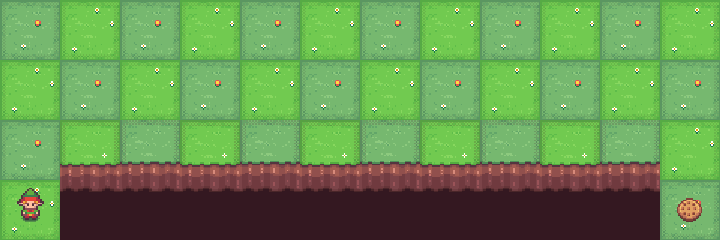

In [12]:
Image('./trained_CliffWalking-v1_eps_09.gif')